In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,random_split,Dataset,ConcatDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import random
import cv2
import gc

In [2]:
# Define transformations for grayscale and color images
transform_gray = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to tensors
])

transform_color = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
])

# Load the original dataset
train_data      = ImageFolder("train")
test_data       = ImageFolder("test")
validation_data = ImageFolder("validation")

In [3]:
def process_dataset(original_data):
    gray_data = []
    color_data = []

    for image, label in original_data:
        # Resize the image to 128x128 pixels
        image_resized = TF.resize(image, (128, 128))
        
        # Convert the PIL image to a numpy array
        image_np = np.array(image_resized)
        
        # Convert to grayscale
        gray_image = TF.to_grayscale(image_resized)
        gray_image = TF.to_tensor(gray_image).float()  # Convert to tensor and then to float
        
        # Convert to HSV
        hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        h_tensor = torch.tensor(h / 179.0, dtype=torch.float32)
        s_tensor = torch.tensor(s / 255.0, dtype=torch.float32)
        v_tensor = torch.tensor(v / 255.0, dtype=torch.float32)
        hsv_tensor = torch.stack((h_tensor, s_tensor, v_tensor), dim=0)
        
        # Repeat label tensor to match the image shape
        repeated_labels = torch.tensor(label).unsqueeze(0).expand(3, 128, 128)
        
        # Append the grayscale and HSV images to their respective lists
        gray_data.append((gray_image, repeated_labels))
        color_data.append((hsv_tensor, repeated_labels))

    return gray_data, color_data

In [4]:
gray_data_train,      color_data_train      = process_dataset(train_data)
gray_data_test,       color_data_test       = process_dataset(test_data)
gray_data_validation, color_data_validation = process_dataset(validation_data)

In [5]:
print("Size of grayscale dataset:", len(gray_data_train))
print("Size of color dataset:", len(color_data_train))
gray_image_shape = gray_data_train[0][0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
color_image_shape = color_data_train[0][0].shape
print("Shape of the first color image tensor:", color_image_shape)


Size of grayscale dataset: 559
Size of color dataset: 559
Shape of the first grayscale image tensor: torch.Size([1, 128, 128])
Shape of the first color image tensor: torch.Size([3, 128, 128])


In [6]:
def plot_hsv_histograms(color_data, num_samples=3):
    for i in range(num_samples):
        index = random.randint(0, len(color_data) - num_samples)
        hsv_image, _ = color_data[i+index]
        h, s, v = hsv_image

        # Plot histograms
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].hist(h.flatten(), bins=256, color='r')
        axes[0].set_title('Hue Histogram')
        axes[1].hist(s.flatten(), bins=256, color='g')
        axes[1].set_title('Saturation Histogram')
        axes[2].hist(v.flatten(), bins=256, color='b')
        axes[2].set_title('Value Histogram')
        plt.show()

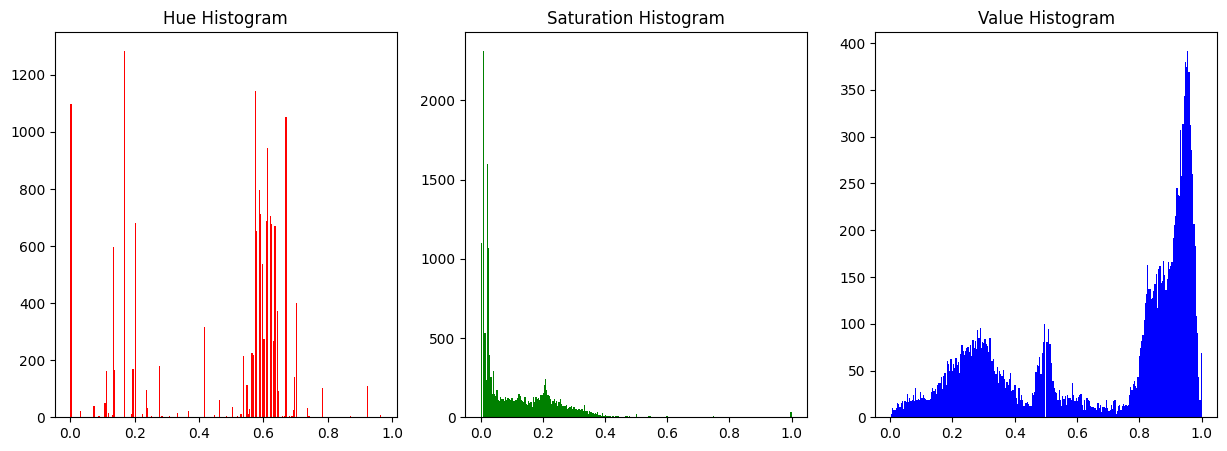

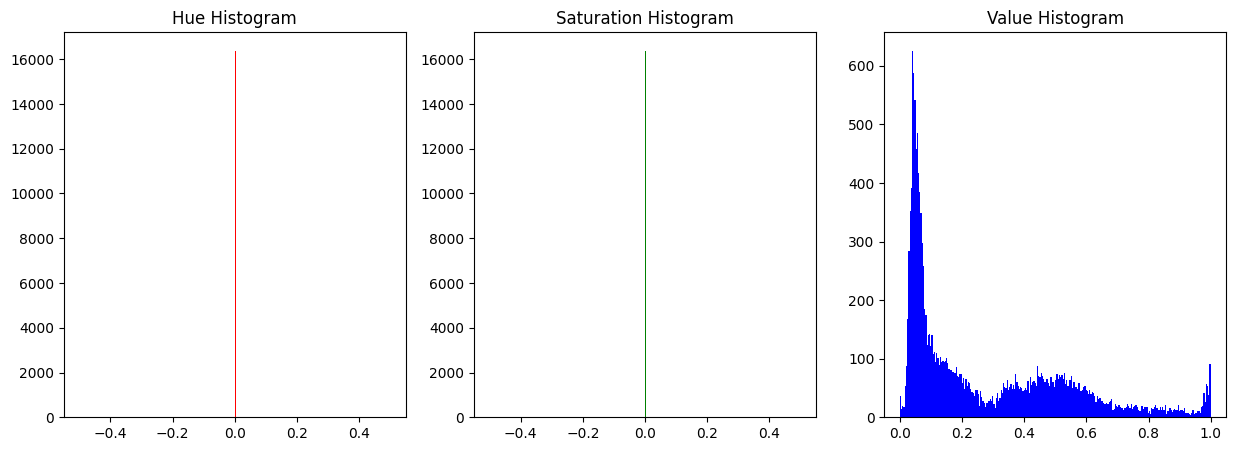

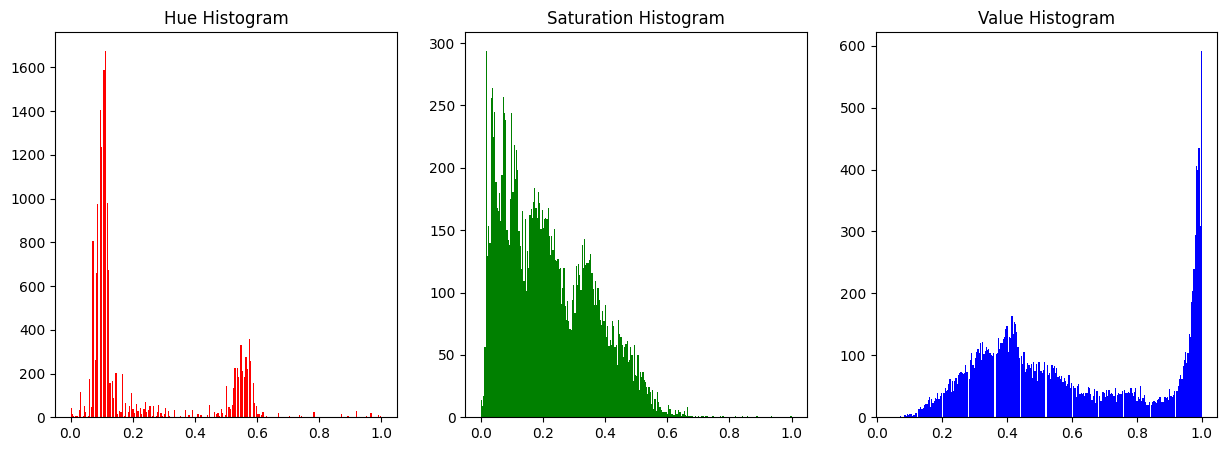

In [7]:
plot_hsv_histograms(color_data_train, num_samples=3)

In [8]:
def visualize_random_images(gray_data, color_data):
    index = random.randint(0, len(gray_data) - 1)
    gray_image, _ = gray_data[index]
    color_image, _ = color_data[index]

    plt.subplot(1, 2, 1)
    plt.imshow(gray_image.squeeze(0), cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hsv_to_rgb(color_image.permute(1, 2, 0)))
    plt.title('Color Image')
    plt.axis('off')
    plt.show()


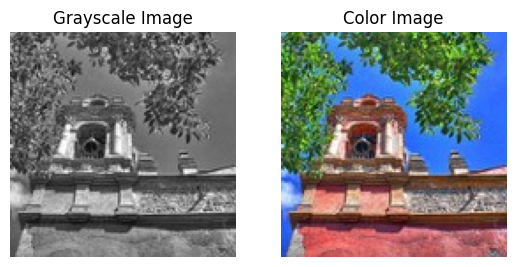

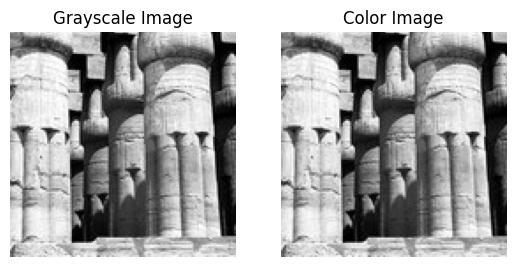

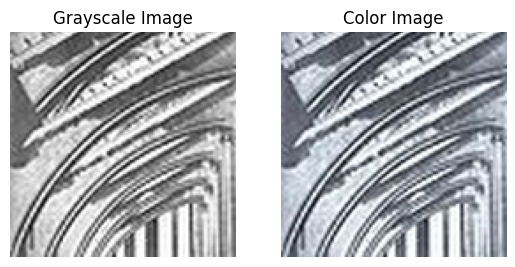

In [9]:
visualize_random_images(gray_data_train,      color_data_train)
visualize_random_images(gray_data_test,       color_data_test)
visualize_random_images(gray_data_validation, color_data_validation)

In [10]:
gray_images_train  = torch.stack([sample[0] for sample in gray_data_train])-0.5
color_images_train = torch.stack([sample[0] for sample in color_data_train])-0.5
gray_images_test   = torch.stack([sample[0] for sample in gray_data_test])-0.5
color_images_test  = torch.stack([sample[0] for sample in color_data_test])-0.5
gray_images_val    = torch.stack([sample[0] for sample in gray_data_validation])-0.5
color_images_val   = torch.stack([sample[0] for sample in color_data_validation])-0.5

dataset_coder = TensorDataset(gray_images_train, gray_images_train)
dataset_train = TensorDataset(gray_images_train, color_images_train)
dataset_test  = TensorDataset(gray_images_test , color_images_test)
dataset_val   = TensorDataset(gray_images_val  , color_images_val)

batch_size = 20
coder_loader = DataLoader(dataset_coder,  batch_size=batch_size,        shuffle=True)
# train_loader = DataLoader(dataset_train,  batch_size=batch_size,        shuffle=True)
val_loader   = DataLoader(dataset_val,     batch_size=len(dataset_val),  shuffle=False)
test_loader  = DataLoader(dataset_test,    batch_size=len(dataset_test), shuffle=False)

In [11]:
for batch_idx, (inputs_gray, targets_color) in enumerate(coder_loader):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break  # Print only the first batch

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([20, 1, 128, 128])
Shape of targets (color images): torch.Size([20, 1, 128, 128])


In [12]:
# num_batches = len(train_loader)
# batch_size = train_loader.batch_size
# print("Number of batches in train_loader: " , num_batches)
# print("Size of each batch in train_loader:", batch_size)
num_batches = len(val_loader)
batch_size = val_loader.batch_size
print("Number of batches in val_loader:   " , num_batches)
print("Size of each batch in val_loader:  ", batch_size)
num_batches = len(test_loader)
batch_size = test_loader.batch_size
print("Number of batches in test_loader:  " , num_batches)
print("Size of each batch in test_loader: ", batch_size)
num_batches = len(coder_loader)
batch_size = coder_loader.batch_size
print("Number of batches in test_loader:  " , num_batches)
print("Size of each batch in test_loader: ", batch_size)

Number of batches in val_loader:    1
Size of each batch in val_loader:   120
Number of batches in test_loader:   1
Size of each batch in test_loader:  179
Number of batches in test_loader:   28
Size of each batch in test_loader:  20


In [13]:
def display_random_image(loader):
    # Extract an image and its corresponding label from the loader
    inputs_gray, targets_color = next(iter(loader))
    index = random.randint(0, len(inputs_gray) - 1) 
    gray_image = inputs_gray[index].squeeze(0)+0.5
    color_image = targets_color[index]+0.5

    # Convert grayscale tensor to numpy array for display
    gray_image_np = gray_image.squeeze().numpy()

    # Convert color image from HSV to RGB using hsv_to_rgb
    color_image_np = hsv_to_rgb(color_image.permute(1, 2, 0).numpy())

    # Display the grayscale image
    plt.subplot(1, 2, 1)
    plt.imshow(gray_image_np, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')

    # Display the color image
    plt.subplot(1, 2, 2)
    plt.imshow(color_image_np)
    plt.title('Color Image')
    plt.axis('off')
    plt.show()

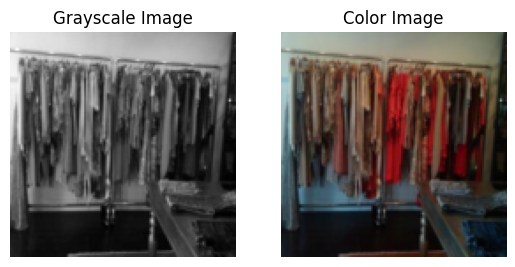

In [14]:
# display_random_image(coder_loader)
display_random_image(test_loader)

In [15]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1 , kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [16]:
model_encoder_decoder = ColorizationModel()
x,y = next(iter(coder_loader))
print(x.shape)
#net1_a(x)
yHat = model_encoder_decoder(x)
model_encoder_decoder.cuda()
print(yHat.shape)
print(y.shape)
summary(model_encoder_decoder, (1, 128, 128))

torch.Size([20, 1, 128, 128])
torch.Size([20, 1, 128, 128])
torch.Size([20, 1, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]          73,792
             ReLU-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]          18,464
             ReLU-12           [-1, 32, 64, 64]               0
  ConvTranspo

In [17]:
def train_model(model, coder_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in coder_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate average training loss
        train_loss = running_loss / len(coder_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, images).item() * images.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch statistics every 5 epochs
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.8  # Reduce learning rate by multiplying with 0.8

    # Return the encoder along with the losses
    return train_losses, val_losses, model.encoder, model


In [18]:
model_encoder_decoder = ColorizationModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_encoder_decoder.parameters(), lr=0.001)
epochs = 20
# Train the model
train_losses, val_losses, model_encoder_trained, model = train_model(model_encoder_decoder, coder_loader, val_loader, criterion, optimizer, epochs)

Epoch 5/20, Train Loss: 0.0074, Val Loss: 0.0070
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0046


In [ ]:
def plot_losses(train_losses_list, val_losses_list):
    plt.figure(figsize=(10, 6))

    # Plot training losses
    if isinstance(train_losses_list[0], list):
        for i, train_losses in enumerate(train_losses_list):
            plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Model {i+1} - Train Loss")
    else:
        plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="Train Loss")

    # Plot validation losses
    if isinstance(val_losses_list[0], list):
        for i, val_losses in enumerate(val_losses_list):
            plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Model {i+1} - Validation Loss", linestyle='--')
    else:
        plt.plot(range(1, len(val_losses_list) + 1), val_losses_list, label="Validation Loss", linestyle='--')

    plt.title("Train and Validation Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
def visualize_and_save_colorization(model, test_loader):
    model.eval()
    with torch.no_grad():
        # Get one batch of data
        grayscale_image, _ = next(iter(test_loader))

        # Generate colorized image
        colorized_image = model(grayscale_image)

        # Remove batch dimension
        grayscale_image = grayscale_image[0]
        colorized_image = colorized_image[0]
        
        # Convert tensors to numpy arrays for visualization
        grayscale_image_np = grayscale_image[0].numpy()+0.5
        colorized_image_np = colorized_image[0].numpy()+0.5
        # Plot the original grayscale and colorized images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(grayscale_image_np, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(colorized_image_np, cmap='gray')
        plt.title('Colorized Image')
        plt.axis('off')

        # Save the figure
        plt.show()

In [ ]:
visualize_and_save_colorization(model, coder_loader)

In [ ]:
class ColorizationModel_a(nn.Module):
    def __init__(self ):#,  encoder):
        super(ColorizationModel_a, self).__init__()
        # Use the provided encoder as the encoder of the new model
        # self.encoder = encoder
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3 , kernel_size=3, stride=1, padding=1),  # Output has 3 channels
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        # x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [ ]:
class ColorizationModel_b(nn.Module):
    def __init__(self):
        super(ColorizationModel_b, self).__init__()
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3 , kernel_size=3, stride=1, padding=1),  # Output has 3 channels
            nn.Tanh()
        )

    def forward(self, x):
        # Decoder
        x = self.decoder(x)
        
        return x

In [ ]:
net1_a = ColorizationModel_a()
x,y = next(iter(val_loader))
print(model_encoder_trained(x).shape)
#net1_a(x)
yHat = net1_a(model_encoder_trained(x))
net1_a.cuda()
print(yHat.shape)
print(y.shape)
summary(net1_a, (128, 16, 16))

In [ ]:
net1_b = ColorizationModel_b()
x,y = next(iter(val_loader))
print(model_encoder_trained(x).shape)
#net1_a(x)
yHat = net1_b(model_encoder_trained(x))
net1_b.cuda()
print(yHat.shape)
print(y.shape)
summary(net1_b, (128, 16, 16))

In [ ]:
gray_data_train_from_decoder = model_encoder_trained(gray_images_train)
gray_data_val_from_decoder   = model_encoder_trained(gray_images_val  )

dataset_train            = TensorDataset(gray_data_train_from_decoder, color_images_train)
dataset_val_from_decoder = TensorDataset(gray_data_val_from_decoder  , color_images_val  )

batch_size = 10
train_loader            = DataLoader(dataset_train           , batch_size = batch_size      , shuffle=True)
val_loader_from_decoder = DataLoader(dataset_val_from_decoder,  batch_size=len(dataset_test), shuffle=False)

In [ ]:
for batch_idx, (inputs_gray, targets_color) in enumerate(val_loader_from_decoder):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
num_batches = len(val_loader_from_decoder)
batch_size = val_loader_from_decoder.batch_size
print("Number of batches in val_loader:   " , num_batches)
print("Size of each batch in val_loader:  ", batch_size)
print(gray_data_val_from_decoder.shape)

In [ ]:
def train(net, criterion, optimizer, train_loader, val_loader, epochs=10):
    best_loss = float('inf')  # Initialize best loss with infinity
    best_model = None
    val_losses = []  # List to store validation losses for each epoch
    train_losses = []  # List to store training losses for each epoch

    for epoch in range(epochs):
        net.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Training phase
        for batch_idx, (inputs_gray, targets_color) in enumerate(train_loader):
            optimizer.zero_grad()  # Clear gradients
            outputs = net(inputs_gray).float()
            loss = criterion(outputs, targets_color.float())
            loss.backward(retain_graph=True)  # Compute gradients
            optimizer.step()  # Update weights
            running_loss += loss.item() * inputs_gray.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)  # Append the training loss for this epoch

        # Validation phase
        net.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            inputs_gray_val, targets_color_val = next(iter(val_loader))
            outputs_val = net(inputs_gray_val)
            loss_val = criterion(outputs_val, targets_color_val.float())
            val_loss += loss_val.item() * inputs_gray_val.size(0)
                
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)  # Append the validation loss for this epoch
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.6f}")
        # Save the best model based on validation loss
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model = net.state_dict()

    return train_losses, val_losses, best_loss, best_model, net


In [ ]:
def create_colorization_model_a():
    return ColorizationModel_a()

def create_colorization_model_b():
    return ColorizationModel_b()


In [ ]:
epochs = 7
models = [create_colorization_model_a() for _ in range(4)] + [create_colorization_model_b() for _ in range(4)]
# Define the criteria
criterions = [
    nn.MSELoss(), nn.MSELoss(), nn.MSELoss(), nn.MSELoss(),
    nn.MSELoss(), nn.MSELoss(), nn.MSELoss(), nn.MSELoss()]
# Define the optimizers
optimizers = [
    optim.Adam(models[0].parameters(), lr=0.001),
    optim.Adam (models[1].parameters(), lr=0.01 ),
    optim.Adam(models[2].parameters(), lr=0.001),
    optim.Adam (models[3].parameters(), lr=0.01 ),
    optim.Adam(models[4].parameters(), lr=0.001),
    optim.Adam (models[5].parameters(), lr=0.01 ),
    optim.Adam(models[6].parameters(), lr=0.001),
    optim.Adam (models[7].parameters(), lr=0.01 )]
val_losses_list = []
best_accuracies = []
best_models = []
trained_nets = []
train_losses_list = []

# Train models and store results
for idx, (model, criterion, optimizer) in enumerate(zip(models, criterions, optimizers)):
    train_losses, val_losses, best_accuracy, best_model, trained_net = train(model, criterion, optimizer, train_loader, val_loader_from_decoder, epochs)
    print(f"Training finished for model {idx + 1 }.")
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    best_accuracies.append(best_accuracy)
    best_models.append(best_model)
    trained_nets.append(trained_net)

In [ ]:
plot_losses(train_losses_list,val_losses_list)

In [ ]:
def normalize_sex_output(output):
    output = output.clone().detach()

    # Apply softmax function to normalize probabilities
    normalized_output = torch.nn.functional.softmax(output, dim=1)

    return normalized_output



In [ ]:
def visualize_models(models, criterion, optimizer, val_loader_from_decoder):
    # Select a random image from the validation loader
    inputs_gray, targets_color = next(iter(val_loader_from_decoder))
    idx = random.randint(0, len(inputs_gray) - 1)
    input_gray_sample = inputs_gray[idx]
    target_color_sample = targets_color[idx]+0.5
    
    # Create a new figure
    fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(15, 30))
    
    # Plot the original color image
    ax = axes[0, 0]
    ax.imshow(hsv_to_rgb(target_color_sample.permute(1, 2, 0).numpy()))
    ax.set_title("Original Color Image")
    ax.axis('off')
    
    # Plot histograms for original color image
    for i in range(3):
        ax = axes[0, i+1]
        ax.hist(target_color_sample[i].flatten()+0.5, bins=256, color='blue', alpha=0.5)
        ax.set_title(f'Channel {i+1} Histogram')
    
    # Plot the outputs from each model
    for i, model in enumerate(models):
        model.eval()
        outputs = model(input_gray_sample.unsqueeze(0))+0.5
        outputs_clipped = torch.clamp(outputs, 0, 1)
        
        # Plot the output image
        ax = axes[i+1, 0]
        ax.imshow(hsv_to_rgb(outputs_clipped.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)))
        ax.set_title(f"Model {i+1}")
        ax.axis('off')
        
        # Plot histograms for output image
        for j in range(3):
            ax = axes[i+1, (j + 1)]
            ax.hist(outputs_clipped[0, j].detach().cpu().numpy().flatten(), bins=256, color='red', alpha=0.5)
            ax.set_title(f'Model {i+1} Channel {j+1} Histogram')
    
    plt.xlabel(f"Criterion: {criterion.__class__.__name__}\nOptimizer: {optimizer.__class__.__name__}")
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_models(trained_nets, criterion, optimizer, val_loader_from_decoder)

In [ ]:
def create_combined_model_dataloaders(train_loader, val_loader, models, batch_size):
    Hue = 0
    Saturation = 1
    Value = 2
    
    combined_train_loaders_red = create_combined_dataset(train_loader, models, batch_size, Hue, shuffle=True)
    combined_val_loaders_red = create_combined_dataset(val_loader, models, len(val_loader), Hue, shuffle=False)
    
    combined_train_loaders_green = create_combined_dataset(train_loader, models, batch_size, Saturation, shuffle=True)
    combined_val_loaders_green = create_combined_dataset(val_loader, models, len(val_loader), Saturation, shuffle=False)
    
    combined_train_loaders_blue = create_combined_dataset(train_loader, models, batch_size, Value, shuffle=True)
    combined_val_loaders_blue = create_combined_dataset(val_loader, models, len(val_loader), Value, shuffle=False)
    
    return combined_train_loaders_red, combined_val_loaders_red, combined_train_loaders_green, combined_val_loaders_green, combined_train_loaders_blue, combined_val_loaders_blue

def create_combined_dataset(loader, models, batch_size, color_channel, shuffle):
    combined_samples = []
    for gray_images, color_images in loader:
        color_predictions = []
        for model in models:
            # Pass grayscale images through each model to get color predictions
            color_prediction = model(gray_images)
            # Extract the predictions for the specific color channel
            color_prediction_channel = color_prediction[:, color_channel:color_channel+1, :, :]
            color_predictions.append(color_prediction_channel)

        # Concatenate color predictions from all models along the channel dimension
        combined_color_predictions = torch.cat(color_predictions, dim=1)

        # Append combined color predictions and original color image
        combined_samples.append((combined_color_predictions, color_images[:, color_channel:color_channel+1]))

    # Convert combined samples into separate lists
    combined_color_predictions_list, original_color_images_list = zip(*combined_samples)
    
    # Convert combined samples into a TensorDataset
    dataset = TensorDataset(torch.cat(combined_color_predictions_list), torch.cat(original_color_images_list))
    
    # Return DataLoader instance
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [ ]:
batch_size = 5
combined_train_loaders_Hue, combined_val_loaders_Hue, combined_train_loaders_Saturation, combined_val_loaders_Saturation, combined_train_loaders_Value, combined_val_loaders_Value = create_combined_model_dataloaders(train_loader, val_loader_from_decoder, trained_nets, batch_size)


In [ ]:
for batch_idx, (inputs_gray, targets_color) in enumerate(combined_train_loaders_Hue):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break
    # Print only the first batch
    # Print more information as needed

In [ ]:
def display_images_with_model_info(models, criterions, optimizers, combined_loaders):
    # Get the first batch from combined_train_loaders_red
    inputs_gray, targets_color = next(iter(combined_loaders))
    
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    if targets_color is not None:
        print("Shape of targets (color images):", targets_color.shape)
    
    # Display grayscale images
    plt.figure(figsize=(20, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(inputs_gray[0, i].detach().cpu().numpy(), cmap='gray')
        model_index = i 
        option = i
        model = models[i]
        criterion = criterions[i]
        optimizer = optimizers[i]
        plt.title(f"Model {model_index+1} ({model.__class__.__name__}), Option {option}\nCriterion: {criterion.__class__.__name__}\nOptimizer: {optimizer.__class__.__name__}")
        plt.axis('off')
    plt.show()

    # Display color images (if available)
    if targets_color is not None:
        plt.figure(figsize=(2.5, 2.5))
        plt.imshow(targets_color[0, 0].detach().cpu().numpy()*2, cmap='gray')
        plt.title("Color Image \non one channel")
        plt.axis('off')
        plt.show()

In [ ]:
display_images_with_model_info(trained_nets, criterions, optimizers, combined_val_loaders_Hue)

In [ ]:
display_images_with_model_info(trained_nets, criterions, optimizers, combined_val_loaders_Saturation)

In [ ]:
display_images_with_model_info(trained_nets, criterions, optimizers, combined_val_loaders_Value)

In [ ]:
class ColorCombinationModel(nn.Module):
    def __init__(self):
        super(ColorCombinationModel, self).__init__()
        # Define convolutional layers to process input channels
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=30, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=1, kernel_size=3, padding=1)
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
model_Color_Combination = ColorCombinationModel()
model_Color_Combination.cuda()
summary(model_Color_Combination,(8,128,128))

In [ ]:
def create_ColorCombinationModel():
    return ColorCombinationModel()

In [ ]:
model_Hue        = create_ColorCombinationModel()
model_Saturation = create_ColorCombinationModel()
model_Value      = create_ColorCombinationModel()

# Use separate optimizers for each model
optimizer_Hue        = optim.Adam(model_Hue.parameters()       , lr=0.001)
optimizer_Saturation = optim.Adam(model_Saturation.parameters(), lr=0.001)
optimizer_Value      = optim.Adam(model_Value.parameters()     , lr=0.001)

# Use separate loss functions for each color channel
loss_fun_Hue        = nn.MSELoss()
loss_fun_Saturation = nn.MSELoss()
loss_fun_Value      = nn.MSELoss()

input_tensor = torch.randn(2, 8, 128, 128)
output_tensor = model_Hue(input_tensor)

# print(model_Hue)
print(output_tensor.shape) 


In [ ]:
def train_model(model, optimizer, loss_fun, train_loader, val_loader, epochs=10):
    train_losses = []
    val_losses = []  # For storing validation losses
    best_model = None
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()  # Set the model to train mode
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            loss.backward(retain_graph=True)  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
        
        # Calculate average loss for training set
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fun(outputs, labels)
                val_loss += loss.item()

        # Calculate average loss for validation set
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_model = model
            best_val_loss = val_loss
    
    return train_losses, val_losses, best_model


In [ ]:
num_epochs_Color = 10
train_losses_Hue,        val_losses_Hue,        best_model_Hue        = train_model(model_Hue,   optimizer_Hue,   loss_fun_Hue,   combined_train_loaders_Hue,   combined_val_loaders_Hue,   epochs=num_epochs_Color)
print(f"Training finished for Hue.")
train_losses_Saturation, val_losses_Saturation, best_model_Saturation = train_model(model_Saturation, optimizer_Saturation, loss_fun_Saturation, combined_train_loaders_Saturation, combined_val_loaders_Saturation, epochs=num_epochs_Color)
print(f"Training finished for Saturation.")
train_losses_Value,      val_losses_Value,      best_model_Value      = train_model(model_Value,  optimizer_Value,  loss_fun_Value,  combined_train_loaders_Value,  combined_val_loaders_Value,  epochs=num_epochs_Color)
print(f"Training finished for Value.")

In [ ]:
plot_losses([train_losses_Hue, train_losses_Saturation, train_losses_Value], [val_losses_Hue, val_losses_Saturation, val_losses_Value])

In [ ]:
def load_models():
    # Fixed paths to model state dictionaries
    encoder_path = 'model_encoder_trained.pth'
    model_paths_a =['model_1.pth', 'model_2.pth', 'model_3.pth', 'model_4.pth']
    model_paths_b =['model_5.pth', 'model_6.pth', 'model_7.pth', 'model_8.pth'] 
    hue_path = 'model_Hue.pth'
    saturation_path = 'model_Saturation.pth'
    value_path = 'model_Value.pth'
    
    Auto_encoder = ColorizationModel()
    encoder = Auto_encoder.encoder
    encoder.load_state_dict(torch.load(encoder_path))

    # Load other models
    models = []
    for path in model_paths_a:
        model = create_colorization_model_a()
        model.load_state_dict(torch.load(path))
        models.append(model)
    for path in model_paths_b:
        model = create_colorization_model_b()
        model.load_state_dict(torch.load(path))
        models.append(model)
    # Load hue model
    hue_model = create_ColorCombinationModel()
    hue_model.load_state_dict(torch.load(hue_path))

    # Load saturation model
    saturation_model = create_ColorCombinationModel()
    saturation_model.load_state_dict(torch.load(saturation_path))

    # Load value model
    value_model = create_ColorCombinationModel()
    value_model.load_state_dict(torch.load(value_path))

    return encoder, models, hue_model, saturation_model, value_model

In [ ]:
def combine_models(model_encoder, models, model_Hue, model_Saturation, model_Value, grayscale_image):
    # Pass the grayscale image through the encoder
    encoded_image = model_encoder(grayscale_image)
    
    # Initialize lists to store outputs from individual models
    hue_outputs = []
    saturation_outputs = []
    value_outputs = []
    
    # Iterate through each model and generate HSV outputs
    for model in models:
        hsv_output = model(encoded_image)
        # Split HSV output into individual channels
        hue_channel = hsv_output[:, 0:1, :, :]
        saturation_channel = hsv_output[:, 1:2, :, :]
        value_channel = hsv_output[:, 2:3, :, :]
        
        # Append each channel to respective lists
        hue_outputs.append(hue_channel)
        saturation_outputs.append(saturation_channel)
        value_outputs.append(value_channel)
    
    # Combine the outputs from all models
    combined_hue_output = torch.cat(hue_outputs, dim=1)
    combined_saturation_output = torch.cat(saturation_outputs, dim=1)
    combined_value_output = torch.cat(value_outputs, dim=1)
    
    # Combine the outputs to create HSV images
    colorized_image_hue = model_Hue(combined_hue_output)
    colorized_image_saturation = model_Saturation(combined_saturation_output)
    colorized_image_value = model_Value(combined_value_output)
    
    # Combine the colorized images into one
    colorized_image = torch.cat([colorized_image_hue, colorized_image_saturation, colorized_image_value], dim=1)
    
    return colorized_image

In [ ]:
def visualize_color_enhancement(model_encoder_trained, trained_nets, best_model_Hue, best_model_Saturation, best_model_Value, test_loader):
    inputs_gray, targets_color = next(iter(test_loader))    
    idx = random.randint(0, len(inputs_gray) - 1)
    grayscale_img = inputs_gray[idx].unsqueeze(0)
    color_img = targets_color[idx]+0.5
    
    # Generate colorized image using combine_models function
    stacked_channels = 0.5 + combine_models(model_encoder_trained, trained_nets, best_model_Hue, best_model_Saturation, best_model_Value, grayscale_img)

    # Convert concatenated channels to RGB
    stacked_rgb = hsv_to_rgb(stacked_channels.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

    # Convert original image to RGB for visualization
    original_rgb = hsv_to_rgb(color_img.permute(1, 2, 0).numpy())

    # Clip pixel values to [0, 1] range
    stacked_rgb = np.clip(stacked_rgb, 0, 1)
    original_rgb = np.clip(original_rgb, 0, 1)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Display the prediction result
    plt.subplot(1, 2, 2)
    plt.imshow(stacked_rgb)
    plt.title('Prediction Result')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_color_enhancement(model_encoder_trained, trained_nets, best_model_Hue, best_model_Saturation, best_model_Value, test_loader)

In [ ]:
encoder_model_old, models_old, hue_model_old, saturation_model_old, value_model_old = load_models()

In [ ]:
x, y = next(iter(val_loader))

# Calculate old loss
old_val_image = combine_models(encoder_model_old, models_old, hue_model_old, saturation_model_old, value_model_old, x)
loss_mse_old = nn.MSELoss()(old_val_image, y)

# Calculate new loss
new_val_image = combine_models(model_encoder_trained, trained_nets, best_model_Hue, best_model_Saturation, best_model_Value, x)
loss_mse_new = nn.MSELoss()(new_val_image, y)

print(loss_mse_old)
print(loss_mse_new)


In [ ]:
if loss_mse_new < loss_mse_old:
    torch.save(model_encoder_trained.state_dict(), 'model_encoder_trained.pth')
    for i, model in enumerate(trained_nets):
        model_path = f"model_{i+1}.pth"  # Generate a unique file name for each model
        torch.save(model.state_dict(), model_path)
    torch.save(model_Hue.state_dict(), 'model_Hue.pth')
    torch.save(model_Saturation.state_dict(), 'model_Saturation.pth')
    torch.save(model_Value.state_dict(), 'model_Value.pth')